In [21]:
import pandas as pd
from tqdm import tqdm
import tiktoken
import os
import matplotlib.pyplot as plt
import umap
%matplotlib inline

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from openai import OpenAI

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Embed letters


In [3]:
output_file = "data/vg_letters.csv" # Output CSV written as part of the steps in parse_letters.ipynb
letters = pd.read_csv(output_file)

In [4]:
EMBEDDING_MODEL = "text-embedding-ada-002"  # https://platform.openai.com/docs/guides/embeddings/what-are-embeddings
embeddings = client.embeddings.create(model=EMBEDDING_MODEL, input=letters['Text'][0])

### Helper functions

All functions are obtained from OpenAI's cookbook: [Embedding Wikipedia articles for search](https://cookbook.openai.com/examples/embedding_wikipedia_articles_for_search). 


In [5]:
GPT_MODEL = "gpt-3.5-turbo"  # only matters insofar as it selects which tokenizer to use

def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))


def halved_by_delimiter(string: str, delimiter: str = "\n") -> list[str, str]:
    """Split a string in two, on a delimiter, trying to balance tokens on each side."""
    chunks = string.split(delimiter)
    if len(chunks) == 1:
        return [string, ""]  # no delimiter found
    elif len(chunks) == 2:
        return chunks  # no need to search for halfway point
    else:
        total_tokens = num_tokens(string)
        halfway = total_tokens // 2
        best_diff = halfway
        for i, chunk in enumerate(chunks):
            left = delimiter.join(chunks[: i + 1])
            left_tokens = num_tokens(left)
            diff = abs(halfway - left_tokens)
            if diff >= best_diff:
                break
            else:
                best_diff = diff
        left = delimiter.join(chunks[:i])
        right = delimiter.join(chunks[i:])
        return [left, right]


def truncated_string(
    string: str,
    model: str,
    max_tokens: int,
    print_warning: bool = True,
) -> str:
    """Truncate a string to a maximum number of tokens."""
    encoding = tiktoken.encoding_for_model(model)
    encoded_string = encoding.encode(string)
    truncated_string = encoding.decode(encoded_string[:max_tokens])
    if print_warning and len(encoded_string) > max_tokens:
        print(f"Warning: Truncated string from {len(encoded_string)} tokens to {max_tokens} tokens.")
    return truncated_string


def split_strings_from_subsection(
    string: str,
    max_tokens: int = 1000,
    model: str = GPT_MODEL,
    max_recursion: int = 5,
) -> list[str]:
    """
    Split a subsection into a list of subsections, each with no more than max_tokens.
    Each subsection is a tuple of parent titles [H1, H2, ...] and text (str).
    """
    num_tokens_in_string = num_tokens(string)
    # if length is fine, return string
    if num_tokens_in_string <= max_tokens:
        return [string]
    # if recursion hasn't found a split after X iterations, just truncate
    elif max_recursion == 0:
        return [truncated_string(string, model=model, max_tokens=max_tokens)]
    # otherwise, split in half and recurse
    else:
        text = string
        for delimiter in ["\n\n", "\n", ". "]:
            left, right = halved_by_delimiter(text, delimiter=delimiter)
            if left == "" or right == "":
                # if either half is empty, retry with a more fine-grained delimiter
                continue
            else:
                # recurse on each half
                results = []
                for half in [left, right]:
                    half_subsection = half
                    half_strings = split_strings_from_subsection(
                        half_subsection,
                        max_tokens=max_tokens,
                        model=model,
                        max_recursion=max_recursion - 1,
                    )
                    results.extend(half_strings)
                return results
    # otherwise no split was found, so just truncate (should be very rare)
    return [truncated_string(string, model=model, max_tokens=max_tokens)]



In [6]:
# Check how many letters have more than 1600 tokens to see whether chunking is needed
n = 0
PRINTED_ONCE = False
for i in tqdm(range(len(letters))):
    t = num_tokens(letters['Text'][i])
    if t > 1600:
        n+=1 
        # Output one example link for a long letter with more than 1600 tokens
        if not PRINTED_ONCE:
            print(f"{t} tokens: {letters['PDF Link'][i]}")
            LONG_LETTER_IDX = i 
            PRINTED_ONCE = True

print(f"{n} letters have more than 1600 tokens.")    

  0%|          | 0/864 [00:00<?, ?it/s]

 27%|██▋       | 230/864 [00:01<00:02, 255.77it/s]

1617 tokens: http://www.vggallery.com/letters/088_V-T_076.pdf


100%|██████████| 864/864 [00:02<00:00, 418.14it/s]

227 letters have more than 1600 tokens.


In [7]:
# Check how the splitting works for the long letter example
split_strings_from_subsection(letters.Text[LONG_LETTER_IDX], max_tokens=1600, model=GPT_MODEL, max_recursion=10)

['\nLetter 076 Isleworth, October 7 1876 Dear Theo,\nIt is Saturday again and I write once more. How I long to see you again, Oh! my longing is sometimes so strong. Write soon, a little word as to how you are. Last Wednesday we took a long walk to a village an hour\'s distance from here. The road led through meadows and fields, along hedges of hawthorn, full of blackberries and clematis, and here and there a large elm tree. It was so beautiful when the sun set behind the grey clouds, and the shadows were long. By chance we met the school of Mr. Stokes, where there are still several of the boys I knew. The clouds retained their red hue long after the sun had set and the dusk had settled over the fields, and we saw in the distance the lamps lit in the village. While I was writing to you, I was called to Mr. Jones, who asked if I would walk to London to collect some money for him. And when I came home in the evening, hurrah, there was a letter from Father with tidings about you. How I sho

### Split letters into chunks

In [8]:
# Split letters into chunks
MAX_TOKENS = 1600
vgogh_letter_chunks = []
idxs = []

for idx, letter in tqdm(letters.iterrows()):
   split_result = split_strings_from_subsection(letter.Text, max_tokens=MAX_TOKENS)
   vgogh_letter_chunks.extend(split_result)
   len_chunks = len(split_result)
   idxs.extend([idx] * len_chunks)

# Join chunks to their letter metadata and drop the full, original text
vgogh_letter_chunks_df = pd.DataFrame({'chunk': vgogh_letter_chunks, 'idx': idxs}).set_index('idx').join(letters).drop('Text', axis=1)

864it [00:06, 125.16it/s]


In [9]:
vgogh_letter_chunks_df.head()

,chunk,Number,Date,Origin,From,To,PDF Link
0,"\nLetter 001 The Hague, c. 18 August 1872 Dear...",1,"August, 1872",T-H,VvG,TvG,http://www.vggallery.com/letters/001_V-T_001.pdf
1,"\nLetter 002 The Hague, 13 Dec 1872 Dear Theo,...",2,13 December 1872,T-H,VvG,TvG,http://www.vggallery.com/letters/002_V-T_002.pdf
2,"\nLetter 003 The Hague, January 1873 My dear T...",3,"January, 1873",T-H,VvG,TvG,http://www.vggallery.com/letters/003_V-T_003.pdf
3,"\nLetter 004 The Hague, January 28 1873 Dear T...",4,28 January 1873,T-H,VvG,TvG,http://www.vggallery.com/letters/004_V-T_004.pdf
4,"\nLetter 005 The Hague, 17 March 1873 Dear The...",5,17 March 1873,T-H,VvG,TvG,http://www.vggallery.com/letters/005_V-T_005.pdf


In [10]:
len(vgogh_letter_chunks_df)

1158

### Get embeddings with OpenAI client

In [11]:
# You can submit up to 2048 embedding inputs per request
# Choose a smaller number to be conservative, since big batches can take a long time to process
BATCH_SIZE = 100  

embeddings = []
for batch_start in range(0, len(vgogh_letter_chunks), BATCH_SIZE):
    batch_end = batch_start + BATCH_SIZE
    batch = vgogh_letter_chunks[batch_start:batch_end]
    print(f"Batch {batch_start} to {min(len(vgogh_letter_chunks), batch_end-1)}")
    response = client.embeddings.create(model=EMBEDDING_MODEL, input=batch)
    for i, be in enumerate(response.data):
        assert i == be.index  # double check embeddings are in same order as input
    batch_embeddings = [e.embedding for e in response.data]
    embeddings.extend(batch_embeddings)

Batch 0 to 99
Batch 100 to 199
Batch 200 to 299
Batch 300 to 399
Batch 400 to 499
Batch 500 to 599
Batch 600 to 699
Batch 700 to 799
Batch 800 to 899
Batch 900 to 999
Batch 1000 to 1099
Batch 1100 to 1158


In [12]:
vgogh_letter_chunks_df['embedding'] = embeddings

In [13]:
# Write to output CSV
vgogh_letter_chunks_df.to_csv("data/letter_embeddings.csv")

## Visualize embeddings

In [15]:
# Reduce dimensionality of embeddings to 2D
umap_model = umap.UMAP(n_components=5, metric='cosine', random_state=42).fit(vgogh_letter_chunks_df.embedding.tolist())

/Users/annamatlin/miniconda3/envs/pdfparse/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [23]:
umap_embeddings = umap_model.transform(vgogh_letter_chunks_df.embedding.tolist())

/var/folders/23/kmz706715cgcgstmj0c9x_c40000gn/T/ipykernel_95434/2231956586.py:2: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



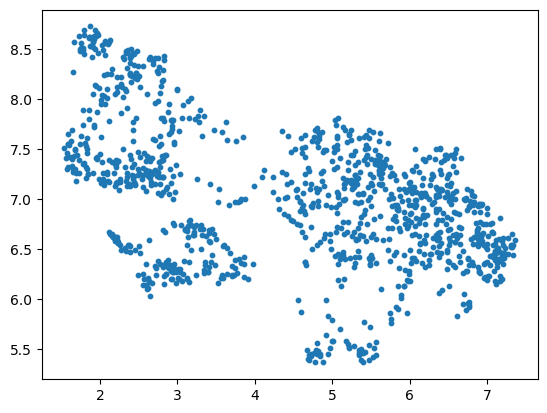

In [25]:
# plot umap embeddings 
plt.scatter(umap_embeddings[:,0], umap_embeddings[:,1], s=10)

In [32]:
# Make it interactive and add the letter author as a color
import plotly.express as px

# Create a Plotly scatter plot using the categorical 'From' column for color
fig = px.scatter(vgogh_letter_chunks_df, 
                 x=umap_embeddings[:, 0], 
                 y=umap_embeddings[:, 1], 
                 color='From',  # Use the categorical column directly
                 hover_data=['From'])  # Include 'From' in hover data

# Customize layout
fig.update_layout(
    title="UMAP Embeddings Colored by 'From'",
    xaxis_title="UMAP 1",
    yaxis_title="UMAP 2",
    legend_title="From"
)

# Show the plot
fig.show()
